This jupyter notebook uses the following reward function to train the Q-Learning model:
$$R(x)=-(x-r)^2$$

# Setup

In [ ]:
!pip install tf-agents

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

from collections import deque

tf.compat.v1.enable_v2_behavior()

from gym import spaces, logger

# Python Environment

In [ ]:
class MotorCartEnvironment(py_environment.PyEnvironment):

  def __init__(self):
    # x'' = alpha x' + beta V
    self.alpha = -1
    self.beta = 10
    self.step_size = 0.2
    
    self.R = 10

    self.high = 2*self.R
    self.low = -self.R

    # Action: [0: Decrease Voltage, 1: Increase Voltage]
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=10, name='action')
    
    # Observation: y = x
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.float32, minimum=np.array([-4*self.R]), maximum=np.array([6*self.R]), name='observation')
    # self._state = np.random.uniform(-0.05,0.05)
    self._state = 0

    # Define x' and V
    # self.x_dot = np.random.uniform(-0.05,0.05)
    self.x_dot = 0
    self.V = 0

    # End the episode if the cart goes past a certain threshold
    self._episode_ended = False

    # End the episode if num_steps > max_steps
    self.max_steps = 50
    self.num_steps = 0

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    # self._state = np.random.uniform(-0.05,0.05)
    # self.x_dot = np.random.uniform(-0.05,0.05)
    self._state = 0
    self.x_dot = 0
    self.V = 0
    self.num_steps = 0

    self._episode_ended = False
    return ts.restart(np.array([self._state], dtype=np.float32))

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return True, self.reset()

    # Update the Voltage according to action
    self.V = action - 5

    # Update x and x' using Euler's Method
    self._state += self.step_size * self.x_dot
    self.x_dot = self.alpha * self.x_dot + self.beta * self.V

    self.num_steps += 1

    reward = -(self._state - self.R)**2

    # if abs(self._state - self.R) < 0.1:
    #   self._episode_ended = True
      # reward = 1000

    if self._state > self.high or self._state < self.low or self.num_steps >= self.max_steps:
      self._episode_ended = True
      # reward = -10000

    if self._episode_ended:
      return True, ts.termination(np.array([self._state], dtype=np.float32), reward)
    else:
      return False, ts.transition(
          np.array([self._state], dtype=np.float32), reward=reward)

In [ ]:
action0 = np.array(0, dtype=np.int32)
action1 = np.array(1, dtype=np.int32)

environment = MotorCartEnvironment()
time_step = environment.reset()
cumulative_reward = time_step.reward
print(time_step)

rewards = []

for _ in range(100):
  done, time_step = environment.step(action1)
  print(done, time_step)
  cumulative_reward += time_step.reward
  if time_step.step_type == 0:
    rewards.append(cumulative_reward)
    cumulative_reward = time_step.reward

print('Final Reward = ', rewards)

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([0.], dtype=float32))
False TimeStep(step_type=array(1, dtype=int32), reward=array(-100., dtype=float32), discount=array(1., dtype=float32), observation=array([0.], dtype=float32))
False TimeStep(step_type=array(1, dtype=int32), reward=array(-324., dtype=float32), discount=array(1., dtype=float32), observation=array([-8.], dtype=float32))
False TimeStep(step_type=array(1, dtype=int32), reward=array(-324., dtype=float32), discount=array(1., dtype=float32), observation=array([-8.], dtype=float32))
True TimeStep(step_type=array(2, dtype=int32), reward=array(-676., dtype=float32), discount=array(0., dtype=float32), observation=array([-16.], dtype=float32))
True TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([0.], dtype=float32))
False TimeStep(step_type=array(1, dtype=int32), reward=a

# Train the Q-Learning Model

In [ ]:
import random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
import pandas as pd

np.random.seed(0)
random.seed(0)

class Agent():
    def __init__(self, env, epsilon=1.0, alpha=0.05, gamma=0.9, num_hands_to_train=30000):
        self.env = env

        # Looks like n is number of valid actions from the souce code
        self.valid_actions = list(range(11))

        # Set parameters of the learning agent
        self.Q = dict()          # Q-table 
        self.epsilon = epsilon   # Random exploration rate
        self.alpha = alpha       # Learning rate
        self.gamma = gamma       # Discount rate- closer to 1 learns well into distant future

        self.num_hands_to_train = num_hands_to_train # Change epsilon each episode based on this
        self.small_decrement = (0.1 * epsilon) / (0.3 * num_hands_to_train) # reduces epsilon slowly
        self.big_decrement = (0.8 * epsilon) / (0.4 * num_hands_to_train) # reduces epilon faster

        self.num_hands_to_train_left = num_hands_to_train

    def update_parameters(self):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
        if self.num_hands_to_train_left > 0.7 * self.num_hands_to_train:
            self.epsilon -= self.small_decrement
        elif self.num_hands_to_train_left > 0.3 * self.num_hands_to_train:
            self.epsilon -= self.big_decrement
        elif self.num_hands_to_train_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.0
            self.alpha = 0.0

        self.num_hands_to_train_left -= 1

    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())

    def choose_action(self, observation):
        """
        Choose which action to take, based on the observation.
        If observation is seen for the first time, initialize its Q values to 0.0
        """
        self.create_Q_if_new_observation(observation)

        # uniformly distributed random number > epsilon happens with probability 1-epsilon
        if random.random() > self.epsilon:
            maxQ = self.get_maxQ(observation)

            # multiple actions could have maxQ- pick one at random in that case
            # this is also the case when the Q value for this observation were just set to 0.0
            action = random.choice([k for k in self.Q[observation].keys()
                                    if self.Q[observation][k] == maxQ])
        else:
            action = random.choice(self.valid_actions)

        self.update_parameters()

        return action


    def learn(self, observation, action, reward, next_observation):
        """
        Called after the agent completes an action and receives a reward.
        This function does not consider future rewards
        when conducting learning.
        """

        self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])

In [ ]:
agent = Agent(env=environment)

In [ ]:
import time

num_rounds = 30 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples

In [ ]:
start_time = time.time()

average_rewards = []

state = environment.reset().observation
print(state)

all_positions = np.zeros((num_samples,num_rounds,environment.max_steps), dtype=np.float32)

for sample in range(num_samples):
  round = 0
  total_reward = 0

  sample_positions = np.zeros((num_rounds,environment.max_steps), dtype=np.float32)
  round_positions = np.zeros(environment.max_steps, dtype=np.float32)
  round_actions = np.zeros(environment.max_steps, dtype=np.int32)

  total_rewards = np.zeros(num_rounds)
  while round < num_rounds:

    action = agent.choose_action(state[0])
    done, output = environment.step(action)
    _, reward, _, next_state = output
    # print("Action: "+str(action), "Done: ", done, "Observation: ", next_state, "Reward: ", reward)

    round_positions[environment.num_steps-1] = next_state[0]
    round_actions[environment.num_steps-1] = action-5

    total_reward += reward
    agent.learn(state[0], action, reward, next_state[0])

    if done:

      round_positions[environment.num_steps:] = next_state[0]
      
      print("Positions: ", list(np.round(round_positions[:environment.num_steps],5)), "Voltage: ", list(round_actions[:environment.num_steps]), "Total reward: ", total_reward)

      _, _, _, state = environment.reset()

      sample_positions[round,:] = round_positions

      total_rewards[round] = total_reward

      total_reward = 0

      round += 1

    state = next_state

  all_positions[sample,:,:] = sample_positions
  average_rewards.append(np.mean(total_rewards))

  # if sample % 10 == 0:
  print('Done with sample: ' + str(sample) + str("   --- %s seconds ---" % (time.time() - start_time)))
  print('Epsilon: ', agent.epsilon)

[0.]
Positions:  [0.0, 2.0, 6.0, 0.0, 6.0, -4.0, 4.0, -12.0] Voltage:  [1, 3, -1, 0, -2, -1, -4, -1] Total reward:  -1012.0
Positions:  [0.0, 6.0, 8.0, 4.0, 0.0, 14.0, 6.0, 16.0, 16.0, 22.0] Voltage:  [3, 4, -1, -4, 5, 3, 1, 5, 3, 3] Total reward:  -504.0
Positions:  [0.0, 6.0, -8.0, 8.0, 2.0, 16.0, 2.0, 16.0, -6.0, 24.0] Voltage:  [3, -4, 1, 5, 4, 0, 0, -4, 4, -3] Total reward:  -1096.0
Positions:  [0.0, 4.0, 0.0, 8.0, 6.0, 0.0, 12.0, 8.0, 10.0, 16.0, 10.0, 14.0, 4.0, 24.0] Voltage:  [2, 0, 2, 3, -4, 3, 4, -1, 4, 0, -1, -3, 5, -4] Total reward:  -648.0
Positions:  [0.0, -6.0, -10.0, 0.0, -4.0, -4.0, 6.0, -2.0, 10.0, 8.0, 10.0, 16.0, 18.0, 12.0, 16.0, 8.0, 10.0, -2.0, 4.0, -6.0, 12.0, 0.0, 4.0, 10.0, 12.0, 2.0, 4.0, -8.0, -2.0, -4.0, -12.0] Voltage:  [-3, -5, 3, 3, -2, 5, 1, 2, 5, 0, 4, 4, -2, -1, -2, -3, -5, -3, -2, 4, 3, -4, 5, 4, -4, -4, -5, -3, 2, -5, -5] Total reward:  -3384.0
Positions:  [0.0, 8.0, -2.0, 0.0, -2.0, -10.0, -12.0] Voltage:  [4, -1, -4, 0, -5, -5, 1] Total reward:  

In [ ]:
agent.choose_action(0)

6

In [ ]:
average_rewards[69]

-510.8

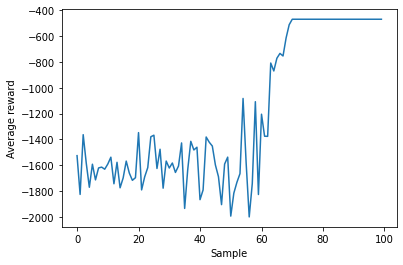

In [ ]:
# Plot payout per 1000 episodes for each value of 'sample'
import matplotlib.pyplot as plt

plt.plot(average_rewards)           
plt.ylabel('Average reward')
plt.xlabel('Sample')
plt.savefig("RL_Plot.png", bbox_inches = "tight")
plt.show()      

In [ ]:
# print(agent.get_optimal_strategy())

# Validation Plot

In [ ]:
agent.Q

{-20.0: {0: -123.12440339242308,
  1: -124.38181575514393,
  2: -127.91830488497787,
  3: -132.75726817168464,
  4: -120.40364977721629,
  5: -118.46611686825192,
  6: -133.83692563410847,
  7: -118.82279223663548,
  8: -117.44989903940474,
  9: -114.10123704476186,
  10: -140.80676387298706},
 -18.0: {0: -193.13041167161936,
  1: -197.37085433785285,
  2: -205.3137027691904,
  3: -206.76766542597647,
  4: -208.95969425737545,
  5: -205.82497719711304,
  6: -208.95740691401284,
  7: -206.96081165785355,
  8: -195.69482102384202,
  9: -191.58521652975136,
  10: -204.25460671646124},
 -16.0: {0: -293.9726516515387,
  1: -320.27346642884146,
  2: -303.7782231196572,
  3: -311.49959367040697,
  4: -302.8219343166507,
  5: -300.75863263280496,
  6: -305.2955623385262,
  7: -303.49586406762546,
  8: -292.7527284038244,
  9: -304.22953732628855,
  10: -293.35823873330696},
 -14.0: {0: -350.00222340835455,
  1: -349.10697371456615,
  2: -348.823649992583,
  3: -351.7294550009144,
  4: -350.715

In [ ]:
state = environment.reset().observation

positions = []

for _ in range(50):
  action = agent.choose_action(state[0])
  done, output = environment.step(action)
  _, reward, _, state = output
  positions.append(state[0])
  print("Voltage: "+str(action-5), "Done: ", done, "Position: ", state[0], "Velocity: ", environment.x_dot, "Reward: ", reward)

Voltage: 1 Done:  False Position:  0.0 Velocity:  10 Reward:  -100.0
Voltage: 1 Done:  False Position:  2.0 Velocity:  0 Reward:  -64.0
Voltage: 1 Done:  False Position:  2.0 Velocity:  10 Reward:  -64.0
Voltage: 1 Done:  False Position:  4.0 Velocity:  0 Reward:  -36.0
Voltage: 3 Done:  False Position:  4.0 Velocity:  30 Reward:  -36.0
Voltage: 3 Done:  False Position:  10.0 Velocity:  0 Reward:  -0.0
Voltage: -1 Done:  False Position:  10.0 Velocity:  -10 Reward:  -0.0
Voltage: -1 Done:  False Position:  8.0 Velocity:  0 Reward:  -4.0
Voltage: 1 Done:  False Position:  8.0 Velocity:  10 Reward:  -4.0
Voltage: 1 Done:  False Position:  10.0 Velocity:  0 Reward:  -0.0
Voltage: -1 Done:  False Position:  10.0 Velocity:  -10 Reward:  -0.0
Voltage: -1 Done:  False Position:  8.0 Velocity:  0 Reward:  -4.0
Voltage: 1 Done:  False Position:  8.0 Velocity:  10 Reward:  -4.0
Voltage: 1 Done:  False Position:  10.0 Velocity:  0 Reward:  -0.0
Voltage: -1 Done:  False Position:  10.0 Velocity:  

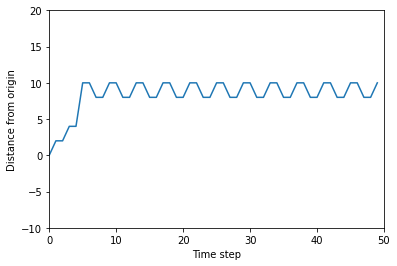

In [ ]:
plt.xlim((0,50))
plt.ylim((-10,20))
plt.xlabel("Time step")
plt.ylabel("Distance from origin")
plt.plot(list(range(len(positions))),positions)
plt.savefig("Reward1Validation")
plt.show()

# Plots

In [ ]:
import matplotlib.pyplot as plt

## Sample 1

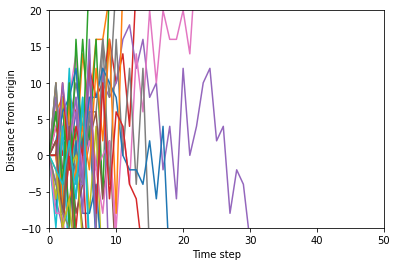

In [ ]:
s1 = list(all_positions[0,:,:])

plt.xlim((0,50))
plt.ylim((-10,20))
plt.xlabel("Time step")
plt.ylabel("Distance from origin")
for i in s1:
  plt.plot(list(range(len(i))),i)
plt.savefig("Reward1Sample1")
plt.show()

## Sample 65

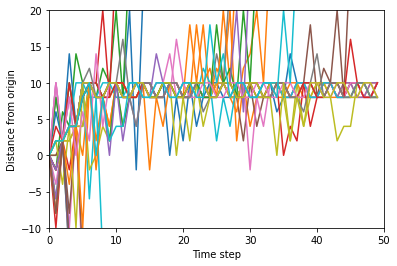

In [ ]:
s65 = list(all_positions[64,:,:])

plt.xlim((0,50))
plt.ylim((-10,20))
plt.xlabel("Time step")
plt.ylabel("Distance from origin")
for i in s33:
  plt.plot(list(range(len(i))),i)
plt.savefig("Reward1Sample65")
plt.show()

## Sample 100

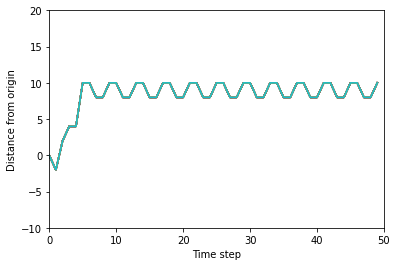

In [ ]:
s100 = list(all_positions[99,:,:])

plt.xlim((0,50))
plt.ylim((-10,20))
plt.xlabel("Time step")
plt.ylabel("Distance from origin")
for i in s100:
  plt.plot(list(range(len(i))),i)
plt.savefig("Reward1Sample100")
plt.show()